# observing-hares
notebook for simulating observation(s) of hares drawn using `drawing-hares.ipynb`

In [1]:
#stock imports
import numpy as np
import pandas as pd
import json
import scipy
import os
##plotting
import matplotlib.pyplot as plt

#plt.style.use('dark_background')
plt.style.use('default')

## single hare
let's try to get this working for a single hare first, with fairly uninformed observational uncertainties

In [2]:
hare_idx = 42
hare_df = pd.read_json(f'form/hare{hare_idx}/hare{hare_idx}.json')
hare_df

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age,radius,luminosity,star_feh,nu_0_6,nu_0_7,...,nu_0_33,nu_0_34,nu_0_35,nu_0_36,nu_0_37,nu_0_38,nu_0_39,nu_0_40,calc_effective_T,nu_max_n
1231184,0.86,0.010486,0.26,2.3,6.951333,0.843513,0.605188,-0.163215,1164.224062,1339.647865,...,5596.699621,5759.863217,5920.939834,6077.123824,6235.119518,6390.132565,6541.606974,6690.251056,5543.10876,22


[ 5.73452080e+03  1.53930410e+00 -3.29369186e-01  1.22561094e+03
  1.31600821e+03  1.40586324e+03  1.49609864e+03  1.58732606e+03
  1.67923004e+03  1.77094481e+03  1.86295876e+03  1.95538238e+03
  2.04810223e+03  2.14122042e+03  2.23435409e+03  2.32757483e+03]
[ 5.80853140e+03  1.63683216e+00 -1.58527268e-01  1.22605716e+03
  1.31582891e+03  1.40612725e+03  1.49627918e+03  1.58818202e+03
  1.67891276e+03  1.77155019e+03  1.86261046e+03  1.95612123e+03
  2.04864575e+03  2.14067535e+03  2.23527304e+03  2.32738820e+03]


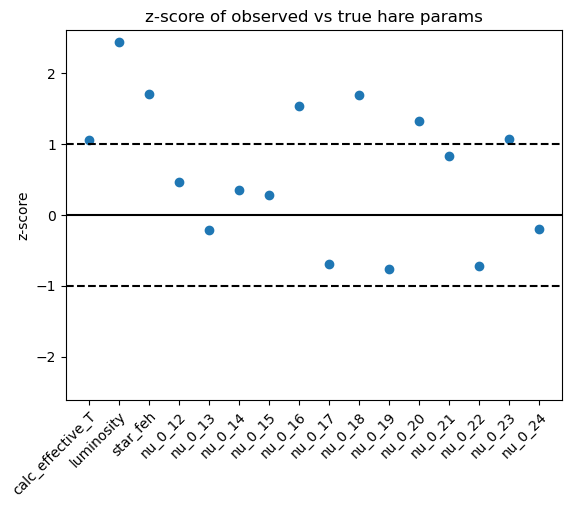

In [3]:
def nu_max_range(nu_max_n, mode_min=8, mode_max=13):
    modes = np.random.randint(mode_min, mode_max)
    flip = np.random.randint(2)
    int_half = int(modes*0.5)
    if flip:
        n_min=nu_max_n-int_half
        n_max=nu_max_n+(modes - int_half)
    else: 
        n_min=nu_max_n-(modes - int_half)
        n_max=nu_max_n+int_half

    return n_min, n_max

def obs_noise(true, unc, seed=None):
    seeded_random_state = np.random.RandomState(seed=seed)
    rvs_random_states = seeded_random_state.randint(0, high=2**32 -1,size=len(true))
    noisy_obs = np.empty(len(true))
    idx = 0
    for ob in true:
        noisy_obs[idx] = scipy.stats.norm(loc=ob, scale=unc[idx]).rvs(random_state=rvs_random_states[idx])
        idx+=1

    return noisy_obs


nu_max_n = hare_df['nu_max_n'].values[0]
n_min, n_max = nu_max_range(nu_max_n)

inputs = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']
outputs = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(n_min, n_max+1)]

hare_cut = hare_df[inputs+outputs]

teff_unc = 70 #K
luminosity_unc = 0.04 #L\odot
surface_feh_unc = 0.1 #dex
frequency_unc = np.random.uniform(0.1,1) #\muHz

obs_unc = np.array([teff_unc, luminosity_unc, surface_feh_unc]+[frequency_unc+abs(i-nu_max_n)*0.1 for i in range(n_min,n_max+1)])

hare_obs = obs_noise(hare_cut.drop(inputs, axis=1).values[0],obs_unc)

print(hare_cut[outputs].values[0])
print(hare_obs)

fig, ax = plt.subplots()
ax.scatter(np.arange(0, len(obs_unc)),(hare_obs-hare_cut[outputs].values[0])/obs_unc)
ax.axhline(0, c='black')
ax.axhline(-1, c='black', linestyle='--')
ax.axhline(1, c='black', linestyle='--')

yabs_max = abs(max(ax.get_ylim(), key=abs))
ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
ax.set_xticks(np.arange(0, len(obs_unc)))
ax.set_xticklabels(outputs)
#ax.tick_params(axis='x', labelrotation=90)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_title('z-score of observed vs true hare params')
ax.set_ylabel('z-score')
plt.savefig(f'form/hare{hare_idx}/obs0/true_vs_obs.png', bbox_inches='tight')

## all hares in form

In [10]:
def nu_max_range(nu_max_n, mode_min=8, mode_max=13):
    modes = np.random.randint(mode_min, mode_max)
    flip = np.random.randint(2)
    int_half = int(modes*0.5)
    if flip:
        n_min=nu_max_n-int_half
        n_max=nu_max_n+(modes - int_half)
    else: 
        n_min=nu_max_n-(modes - int_half)
        n_max=nu_max_n+int_half

    return n_min, n_max

def obs_noise(true, unc, seed=None):
    seeded_random_state = np.random.RandomState(seed=seed)
    rvs_random_states = seeded_random_state.randint(0, high=2**32 -1,size=len(true))
    noisy_obs = np.empty(len(true))
    idx = 0
    for ob in true:
        noisy_obs[idx] = scipy.stats.norm(loc=ob, scale=unc[idx]).rvs(random_state=rvs_random_states[idx])
        idx+=1

    return noisy_obs

inputs = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']

teff_unc = 70 #K
luminosity_unc = 0.04 #L\odot
surface_feh_unc = 0.1 #dex


for hare_idx in range(100):
    hare_df = pd.read_json(f'form/hare{hare_idx}/hare{hare_idx}.json')

    nu_max_n = hare_df['nu_max_n'].values[0]
    n_min, n_max = nu_max_range(nu_max_n)
    outputs = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(n_min, n_max+1)]

    hare_cut = hare_df[inputs+outputs]

    frequency_unc = np.random.uniform(0.1,1) #\muHz

    obs_unc = np.array([teff_unc, luminosity_unc, surface_feh_unc]+[frequency_unc+abs(i-nu_max_n)*0.1 for i in range(n_min,n_max+1)])

    hare_obs = obs_noise(hare_cut.drop(inputs, axis=1).values[0],obs_unc)
    
    hare_obs = obs_noise(hare_cut[outputs].values[0],obs_unc)
    hare_obs_df = hare_cut.copy()
    hare_obs_df[outputs] = hare_obs

    

    fig, ax = plt.subplots()
    ax.scatter(np.arange(0, len(obs_unc)),(hare_obs-hare_cut[outputs].values[0])/obs_unc)
    ax.axhline(0, c='black')
    ax.axhline(-1, c='black', linestyle='--')
    ax.axhline(1, c='black', linestyle='--')
    
    yabs_max = abs(max(ax.get_ylim(), key=abs))
    ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
    ax.set_xticks(np.arange(0, len(obs_unc)))
    ax.set_xticklabels(outputs)
    #ax.tick_params(axis='x', labelrotation=90)
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    ax.set_title('z-score of observed vs true hare params')
    ax.set_ylabel('z-score')

    path = f'form/hare{hare_idx}/obs0'
    if not os.path.exists(path):
      os.mkdir(path)
      print(f"{path} created!")
    else:
      print(f"{path} already exists", end='\r')
    hare_obs_df.to_json(path+f'/obs0.json')
    pd.DataFrame([obs_unc], columns=outputs).to_json(path+'/uncs.json')
    plt.savefig(path+'/zscore_plot.png', bbox_inches='tight')
    plt.close()
